In [1]:
from fastai.vision import *


Bad key "text.kerning_factor" on line 4 in
/home/bir2160400081/anaconda3/envs/fastai/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
torch.cuda.set_device(1)

In [3]:
path = untar_data(URLs.CAMVID)
path.ls()

[PosixPath('/home/bir2160400081/.fastai/data/camvid/images'),
 PosixPath('/home/bir2160400081/.fastai/data/camvid/codes.txt'),
 PosixPath('/home/bir2160400081/.fastai/data/camvid/valid.txt'),
 PosixPath('/home/bir2160400081/.fastai/data/camvid/labels')]

In [4]:
path_img = path / "images"
path_label = path / "labels"

In [5]:
path_img.ls()[:5]

[PosixPath('/home/bir2160400081/.fastai/data/camvid/images/Seq05VD_f04920.png'),
 PosixPath('/home/bir2160400081/.fastai/data/camvid/images/0016E5_08073.png'),
 PosixPath('/home/bir2160400081/.fastai/data/camvid/images/0016E5_02250.png'),
 PosixPath('/home/bir2160400081/.fastai/data/camvid/images/Seq05VD_f01470.png'),
 PosixPath('/home/bir2160400081/.fastai/data/camvid/images/0016E5_08081.png')]

In [6]:
path_label.ls()[:5]

[PosixPath('/home/bir2160400081/.fastai/data/camvid/labels/0006R0_f03630_P.png'),
 PosixPath('/home/bir2160400081/.fastai/data/camvid/labels/0001TP_008280_P.png'),
 PosixPath('/home/bir2160400081/.fastai/data/camvid/labels/0001TP_007770_P.png'),
 PosixPath('/home/bir2160400081/.fastai/data/camvid/labels/0016E5_06930_P.png'),
 PosixPath('/home/bir2160400081/.fastai/data/camvid/labels/0016E5_08520_P.png')]

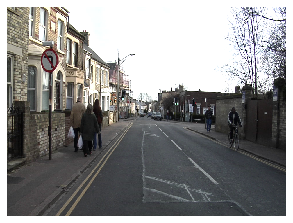

In [7]:
img = open_image(path_img.ls()[0])
img.show(figsize=(5, 5))

In [8]:
get_y_fn = lambda x: path_label/f'{x.stem}_P{x.suffix}'

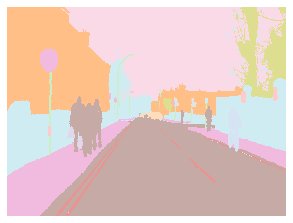

In [9]:
mask = open_mask(get_y_fn(path_img.ls()[0]))
mask.show(figsize=(5, 5))

In [10]:
codes = np.loadtxt(path/'codes.txt', dtype=str)
codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

In [11]:
valid_frame = np.loadtxt(path/'valid.txt', dtype=str)
valid_frame

array(['0016E5_07959.png', '0016E5_07961.png', '0016E5_07963.png', '0016E5_07965.png', ..., '0016E5_08153.png',
       '0016E5_08155.png', '0016E5_08157.png', '0016E5_08159.png'], dtype='<U16')

In [12]:
src = (SegmentationItemList.from_folder(path_img)
       # Load in x data from folder
       .split_by_fname_file(path/'valid.txt')
       # Split data into training and validation set 
       .label_from_func(get_y_fn, classes=codes)
       # Label data using the get_y_fn function
)

In [13]:
tfms = get_transforms()
bs = 16
size= 128

In [14]:
data = (src.transform(tfms, size=size, tfm_y=True)
        # Flip images horizontally 
        .databunch(bs=bs)
        # Create a databunch
        .normalize(imagenet_stats)
        # Normalize for resnet
)

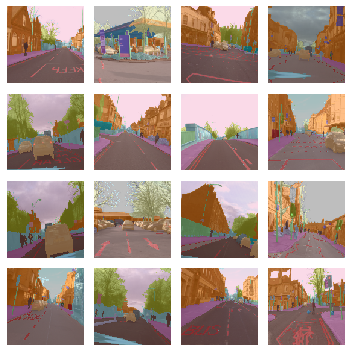

In [15]:
data.show_batch(figsize=(5, 5))

In [16]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [17]:
learn = unet_learner(data, models.resnet50, metrics=acc_camvid, wd=1e-2)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


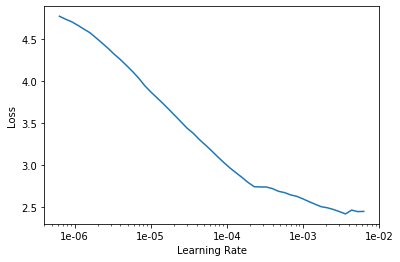

In [18]:
learn.lr_find()
learn.recorder.plot()

In [19]:
lr = 1e-5
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,3.825121,2.988078,0.296168,00:26
1,2.843364,2.018363,0.485269,00:25
2,2.068269,1.330524,0.666189,00:25
3,1.573691,1.051721,0.746959,00:25
4,1.255117,0.854674,0.792801,00:25
5,1.040906,0.745148,0.817247,00:25
6,0.898179,0.748734,0.817036,00:25
7,0.816006,0.715163,0.824000,00:25
8,0.750426,0.617552,0.839295,00:25
9,0.692092,0.611088,0.843231,00:25


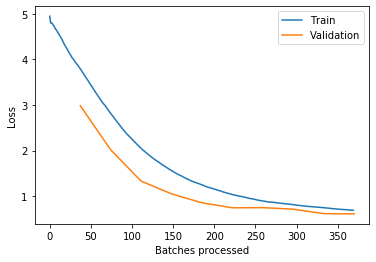

In [20]:
learn.recorder.plot_losses()

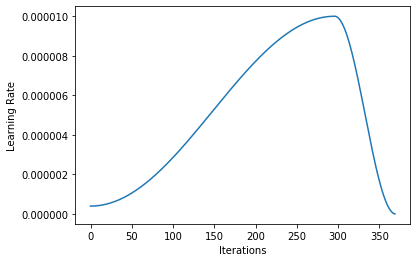

In [21]:
learn.recorder.plot_lr()

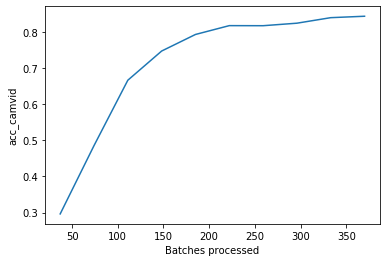

In [22]:
learn.recorder.plot_metrics()

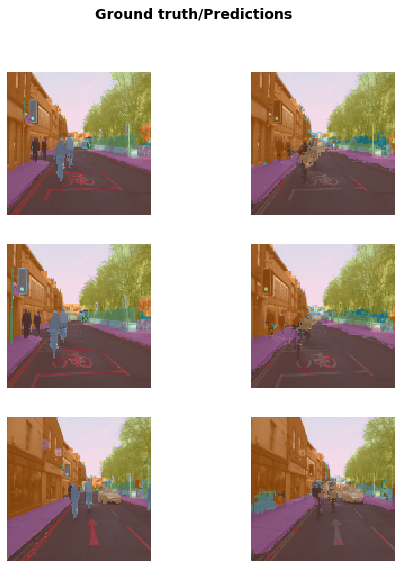

In [23]:
learn.save('camvid-stage-1') # save model
learn.show_results(rows=3, figsize=(8, 9)) # show results

In [24]:
size = 256
bs = 4
data = (src.transform(tfms, size=size, tfm_y=True)
        # Flip images horizontally 
        .databunch(bs=bs)
        # Create a databunch
        .normalize(imagenet_stats)
        # Normalize for resnet
)

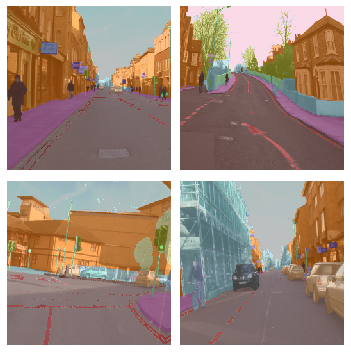

In [25]:
data.show_batch(figsize=(5, 5))

In [26]:
from pynvml import *
nvmlInit()
handle = nvmlDeviceGetHandleByIndex(1)
info = nvmlDeviceGetMemoryInfo(handle)
print("Total memory:", info.total)
print("Free memory:", info.free)
print("Used memory:", info.used)

Total memory: 12788498432
Free memory: 1060175872
Used memory: 11728322560


In [27]:
torch.cuda.empty_cache()

In [28]:
learn = unet_learner(data, models.resnet50, metrics=acc_camvid, wd=1e-2)

In [29]:
learn.load('camvid-stage-1')

Learner(data=ImageDataBunch;

Train: LabelList (600 items)
x: SegmentationItemList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: SegmentationLabelList
ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256)
Path: /home/bir2160400081/.fastai/data/camvid/images;

Valid: LabelList (101 items)
x: SegmentationItemList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: SegmentationLabelList
ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256)
Path: /home/bir2160400081/.fastai/data/camvid/images;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

epoch,train_loss,valid_loss,acc_camvid,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


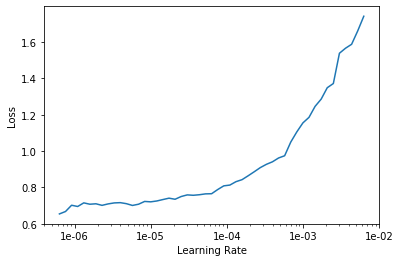

In [30]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [31]:
learn.fit_one_cycle(10, slice(lr/400, lr/4))

epoch,train_loss,valid_loss,acc_camvid,time
0,0.683650,0.687568,0.827330,01:55
1,0.634293,0.604369,0.840006,01:53
2,0.622529,0.562068,0.850202,01:52
3,0.585527,0.539847,0.860186,01:53
4,0.543468,0.503882,0.860466,01:52
5,0.514471,0.514970,0.856357,01:52
6,0.521387,0.509067,0.857744,01:52
7,0.506877,0.471043,0.870292,01:52
8,0.487892,0.485423,0.863856,01:52
9,0.489085,0.476928,0.867497,01:53


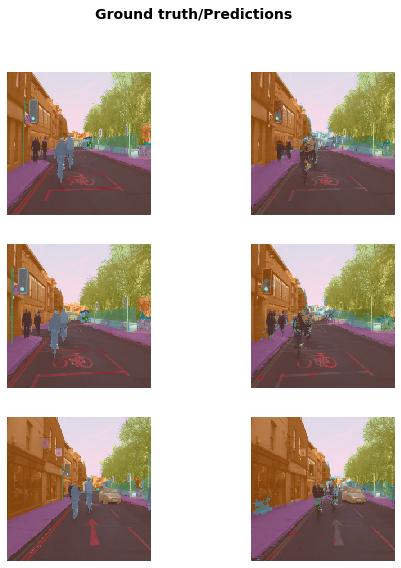

In [32]:
learn.save('camvid-stage-1') # save model
learn.show_results(rows=3, figsize=(8, 9)) # show results

In [39]:
learn.path = Path('/home/bir2160400081/.fastai/data/camvid')
learn.export()

In [41]:
learn = load_learner(path)

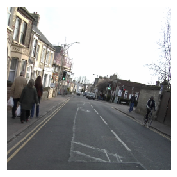

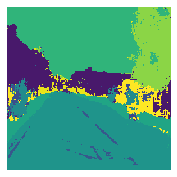

In [45]:
mask_pred = learn.predict(data.train_ds[0][0])
Image.show(data.train_ds[0][0])
Image.show(mask_pred[0])